# Installations

In [1]:
!pip install spotipy
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 140 kB 38.1 MB/s 
     |████████████████████████████████| 246 kB 54.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import plotly.express as px 
import seaborn as sn

from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

In [47]:
dataPath = '/content/data/MyDrive/Projects/Music Recommender'

# Dataset visualization 

In [5]:
dataDF = pd.read_csv(dataPath+'/data.csv')

In [6]:
dataDF.info()
dataDF.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


In [7]:
"""
I will convert the year column so that they reflect their corresponding decade. For instance, the songs (released in) with 2005, 2007, 2002 as years will become 2000
Thus the years will be converted into categorical column. There are fewer decades than there are individual years. In this I will also be able to see if decades
has any impact on the recommendation

Initially, I wanted to convert artist column into a categorical column as well. But the artist column happens contain list of artists. It would be challenging as of now
I intend to tackle this later.
"""

def turnYearIntoDecade(year):
  return (year//10)*10 

In [8]:
dataDF['year'] = dataDF['year'].apply(lambda year : turnYearIntoDecade(year))

In [9]:
dataDF.head(3)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1920,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1920,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1920,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


In [10]:
dataDFNumeric = dataDF.select_dtypes(np.number)
dataDFNumeric.info()
dataDFNumeric.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   danceability      170653 non-null  float64
 4   duration_ms       170653 non-null  int64  
 5   energy            170653 non-null  float64
 6   explicit          170653 non-null  int64  
 7   instrumentalness  170653 non-null  float64
 8   key               170653 non-null  int64  
 9   liveness          170653 non-null  float64
 10  loudness          170653 non-null  float64
 11  mode              170653 non-null  int64  
 12  popularity        170653 non-null  int64  
 13  speechiness       170653 non-null  float64
 14  tempo             170653 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 19.5 MB


,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.0594,1920,0.982,0.279,831667,0.211,0,0.878,10,0.665,-20.096,1,4,0.0366,80.954
1,0.9630,1920,0.732,0.819,180533,0.341,0,0.000,7,0.160,-12.441,1,5,0.4150,60.936
2,0.0394,1920,0.961,0.328,500062,0.166,0,0.913,3,0.101,-14.850,1,5,0.0339,110.339


In [11]:
"""
We can see that popularity has very strong correlation with year [actually decade]. I feel good about using this column now :3
Apart from that danceability, energy, loudness, tempo has good positive correlation with popularity.
Acousticness, instrumentalness has very strong negative correlation with popularity
"""
dataDFNumeric.corr()['popularity']

valence             0.014200
year                0.854456
acousticness       -0.573162
danceability        0.199606
duration_ms         0.059597
energy              0.485005
explicit            0.191543
instrumentalness   -0.296750
key                 0.007826
liveness           -0.076464
loudness            0.457051
mode               -0.028897
popularity          1.000000
speechiness        -0.171979
tempo               0.133310
Name: popularity, dtype: float64

In [12]:
k = 20 #k of kmeans

In [13]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=k, verbose = 1, max_iter=500))])
cluster_pipeline.fit(dataDFNumeric)
clusters = cluster_pipeline.predict(dataDFNumeric)

Initialization complete
Iteration 0, inertia 1511012.7125779742
Iteration 1, inertia 1167787.4920932385
Iteration 2, inertia 1127215.8281711563
Iteration 3, inertia 1113559.131872031
Iteration 4, inertia 1105677.016060997
Iteration 5, inertia 1099402.6291862442
Iteration 6, inertia 1094391.5640047821
Iteration 7, inertia 1090680.8344410234
Iteration 8, inertia 1087928.8714864892
Iteration 9, inertia 1085887.5149591342
Iteration 10, inertia 1084218.47165167
Iteration 11, inertia 1082704.6579980045
Iteration 12, inertia 1081370.26710623
Iteration 13, inertia 1080044.3406529913
Iteration 14, inertia 1078804.7916730985
Iteration 15, inertia 1077748.8701894851
Iteration 16, inertia 1076929.6370923172
Iteration 17, inertia 1076364.291369938
Iteration 18, inertia 1076035.3944735376
Iteration 19, inertia 1075838.320124689
Iteration 20, inertia 1075710.297838739
Iteration 21, inertia 1075619.266963282
Iteration 22, inertia 1075556.6586381067
Iteration 23, inertia 1075510.601884185
Iteration 24,

In [52]:
dataDFNumericSubset = dataDFNumeric[:30000]

In [53]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1, perplexity=40.0, n_iter=500))])
decomposed_vector = tsne_pipeline.fit_transform(dataDFNumericSubset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.075s...
[t-SNE] Computed neighbors for 30000 samples in 25.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for s

We can see from the illustration below that the clustering has not been done properly. There are overlaps between two neighbor clusters. Ideally, I will be iteratively creating clusters with varying values of k. I will use the k that results in the best silhouette value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

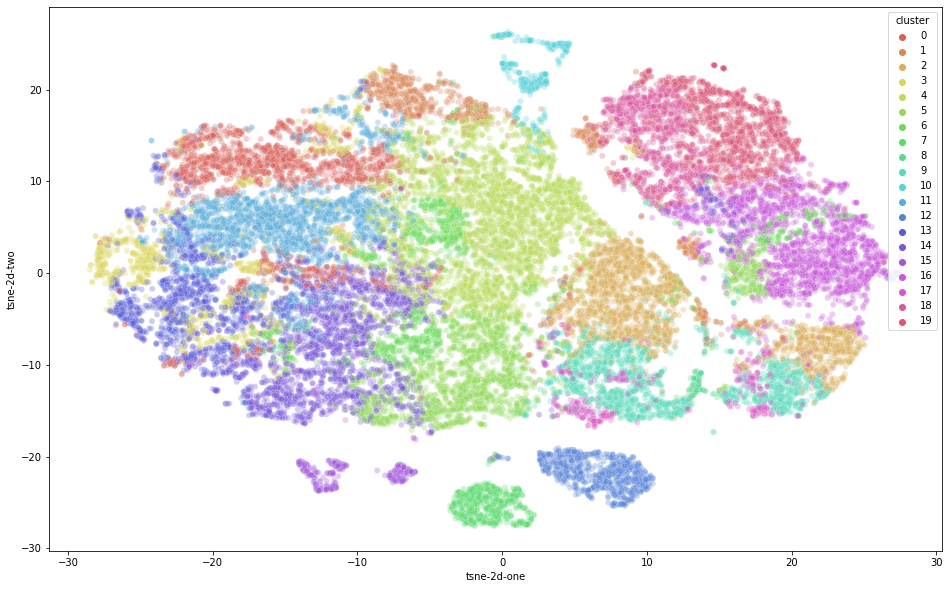

In [54]:
dataDFNumericSubset['tsne-2d-one'] = decomposed_vector[:,0]
dataDFNumericSubset['tsne-2d-two'] = decomposed_vector[:,1]
dataDFNumericSubset['cluster'] = clusters[:30000]
plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sn.color_palette("hls", k),
    data=dataDFNumericSubset,
    legend="full",
    alpha=0.3
)

In [ ]:
"""
I'm choosing silhouette evaluation method and not elbow method. In the elbow method the function monotonically decreases. An elbow or (nearly) inflection point may not appear. 
It would defeat the purpose of the elbow method. Hence, it is not a good indicator.

The returned value of silhouette method is within [-1,1]. 
For the current point,
-1 indicates the  is in the wrong cluster
0 indicates the neighboring cluster is very close to its surrounding cluster
1 indicates the neighboring cluster is far way. Hence, it is in the optimal cluster
"""

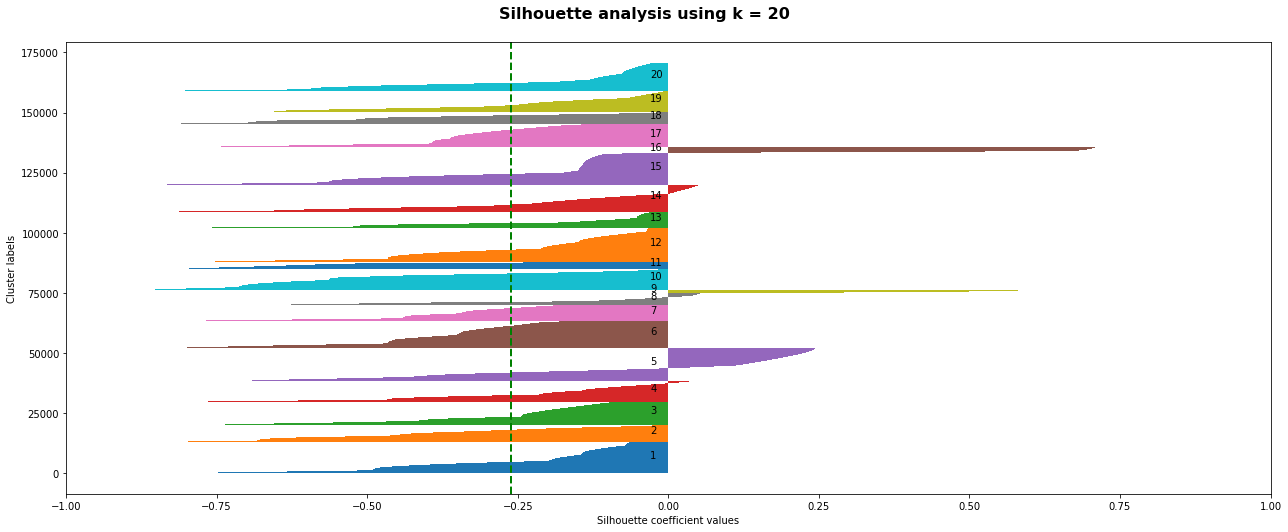

In [14]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)


# Get silhouette samples
silhouette_vals = silhouette_samples(dataDFNumeric, clusters)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(clusters)):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)

# Get the average silhouette score and plot it
avg_score = np.mean(silhouette_vals)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
# ax1.set_yticks([])
ax1.set_xlim([-1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
 
plt.tight_layout()
plt.suptitle(f'Silhouette analysis using k = {k}', fontsize=16, fontweight='semibold', y=1.05);

# Song recommendation

In [30]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [31]:
spotifyCreds = {}
with open(dataPath+'/spotifyAuth.json') as f:
  spotifyCreds = json.load(f)

In [32]:
# playlistLink = "https://open.spotify.com/playlist/2ZpJnHwUXLkdYrwDvlxvdE?si=83b56c2fb3bb405c"
playlistLink = 'https://open.spotify.com/playlist/3KmdgQbFU2vAosAoG2ZIdF?si=fac01b9a74994527'

In [33]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=spotifyCreds['clientID'], client_secret=spotifyCreds['clientSecret'])
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [34]:
def findSongDetails(playListLink, sp):

  playlistURI = playlistLink.split("/")[-1].split("?")[0]
  songListData = []
  
  print("Songs in the playlist:")
  playListInfo = sp.playlist_tracks(playlistURI)
  for track in playListInfo["items"]:
    print(track['track']['name'])
    songData = {}
    
    track_id = track['track']['id']
    audio_features = sp.audio_features(track_id)[0]

    songData['name'] = track['track']['name']
    songData['year'] = (int(track['track']['album']['release_date'].split('-')[0])//10)*10
    songData['explicit'] = int(track['track']['explicit'])
    songData['duration_ms'] = track['track']['duration_ms']
    songData['popularity'] = track['track']['popularity']

    for key, value in audio_features.items():
        songData[key] = value
    songListData.append(songData)

  return pd.DataFrame(songListData)


In [35]:
songListDF = findSongDetails(playlistLink, sp)

Songs in the playlist:
We Don't Talk Anymore (feat. Selena Gomez)
Here to Stay
Love In The Dark
Watch Over You
In Loving Memory
Say Something
Talk to Me
Carry You Home
Fix You
Life is Beautiful


In [36]:
songListDF.info()
songListDF.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              10 non-null     object 
 1   year              10 non-null     int64  
 2   explicit          10 non-null     int64  
 3   duration_ms       10 non-null     int64  
 4   popularity        10 non-null     int64  
 5   danceability      10 non-null     float64
 6   energy            10 non-null     float64
 7   key               10 non-null     int64  
 8   loudness          10 non-null     float64
 9   mode              10 non-null     int64  
 10  speechiness       10 non-null     float64
 11  acousticness      10 non-null     float64
 12  instrumentalness  10 non-null     float64
 13  liveness          10 non-null     float64
 14  valence           10 non-null     float64
 15  tempo             10 non-null     float64
 16  type              10 non-null     object 
 17  

,name,year,explicit,duration_ms,popularity,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,We Don't Talk Anymore (feat. Selena Gomez),2010,0,217707,81,0.728,0.563,1,-8.053,0,...,0.0,0.179,0.352,100.017,audio_features,06KyNuuMOX1ROXRhj787tj,spotify:track:06KyNuuMOX1ROXRhj787tj,https://api.spotify.com/v1/tracks/06KyNuuMOX1R...,https://api.spotify.com/v1/audio-analysis/06Ky...,4
1,Here to Stay,2010,0,259227,40,0.497,0.706,4,-5.978,1,...,0.0,0.237,0.212,134.081,audio_features,483Q9F18uvWW8AchyDNRye,spotify:track:483Q9F18uvWW8AchyDNRye,https://api.spotify.com/v1/tracks/483Q9F18uvWW...,https://api.spotify.com/v1/audio-analysis/483Q...,4
2,Love In The Dark,2010,0,285935,77,0.331,0.341,9,-6.057,0,...,0.0,0.109,0.152,109.821,audio_features,0DuWDLjriRPjDRoPgaCslY,spotify:track:0DuWDLjriRPjDRoPgaCslY,https://api.spotify.com/v1/tracks/0DuWDLjriRPj...,https://api.spotify.com/v1/audio-analysis/0DuW...,4


In [37]:
songListDFNumeric = songListDF.select_dtypes(np.number).drop(axis=1,labels='time_signature')
songListDFNumeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              10 non-null     int64  
 1   explicit          10 non-null     int64  
 2   duration_ms       10 non-null     int64  
 3   popularity        10 non-null     int64  
 4   danceability      10 non-null     float64
 5   energy            10 non-null     float64
 6   key               10 non-null     int64  
 7   loudness          10 non-null     float64
 8   mode              10 non-null     int64  
 9   speechiness       10 non-null     float64
 10  acousticness      10 non-null     float64
 11  instrumentalness  10 non-null     float64
 12  liveness          10 non-null     float64
 13  valence           10 non-null     float64
 14  tempo             10 non-null     float64
dtypes: float64(9), int64(6)
memory usage: 1.3 KB


In [38]:
songListDFNumeric = songListDFNumeric[dataDFNumeric.columns]

In [39]:
songListDFNumeric.info()
songListDFNumeric.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           10 non-null     float64
 1   year              10 non-null     int64  
 2   acousticness      10 non-null     float64
 3   danceability      10 non-null     float64
 4   duration_ms       10 non-null     int64  
 5   energy            10 non-null     float64
 6   explicit          10 non-null     int64  
 7   instrumentalness  10 non-null     float64
 8   key               10 non-null     int64  
 9   liveness          10 non-null     float64
 10  loudness          10 non-null     float64
 11  mode              10 non-null     int64  
 12  popularity        10 non-null     int64  
 13  speechiness       10 non-null     float64
 14  tempo             10 non-null     float64
dtypes: float64(9), int64(6)
memory usage: 1.3 KB


,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.352,2010,0.6210,0.728,217707,0.563,0,0.0,1,0.179,-8.053,0,81,0.1340,100.017
1,0.212,2010,0.0368,0.497,259227,0.706,0,0.0,4,0.237,-5.978,1,40,0.0309,134.081
2,0.152,2010,0.5280,0.331,285935,0.341,0,0.0,9,0.109,-6.057,0,77,0.0309,109.821


In [40]:
def findPlayListMean(playListDF):
  songVectorList = [song for song in playListDF[playListDF.columns].values]
  playlistVector = np.array(songVectorList)
  return np.mean(playlistVector, axis=0).reshape(1, -1)


In [41]:
"""
I can find recommendations in two ways. If the silhouette value is acceptable then I would recommend songs from the playlist's own cluster
Else, I can find songs that are nearest neighbors of the songs in the playlist. 
Acceptable value is >= 0.5
"""

def recommendSong(playlistLink, sp, recommendationType, dataClusters, playListDF=None):
  if playListDF is None:
    playListDF = findSongDetails(playlistLink, sp)
    playListDF.select_dtypes(np.number).drop(axis=1,labels='time_signature')
    playListDF = playListDF[dataDFNumeric.columns]

  #mean of the song (features) will represent the list itself
  playlistMeanVector = findPlayListMean(playListDF)
  songMeanCluster = cluster_pipeline.predict(playlistMeanVector)
  recommendationDF = None

  if recommendationType == 'cluster':
    neighborIdx = dataClusters == songMeanCluster

    clusterNeighborDF = dataDFNumeric.iloc[neighborIdx]
    clusterNeighbor = np.array(clusterNeighborDF[clusterNeighborDF.columns].values)

    distances = cdist(playlistMeanVector, clusterNeighbor).reshape(-1)
    recommendationIdx = np.argpartition(distances, 10)[:10].reshape(-1)

    recommendationDF = dataDF.iloc[neighborIdx].iloc[recommendationIdx]

  elif recommendationType == 'neighbor':
    nearestNeighbor = np.array(dataDFNumeric[dataDFNumeric.columns].values)

    distances = cdist(playlistMeanVector, nearestNeighbor).reshape(-1)
    recommendationIdx = np.argpartition(distances, 10)[:10]

    recommendationDF = dataDF.iloc[recommendationIdx]
  
  return recommendationDF[['name', 'artists', 'year']]


    

In [43]:
recommendationDF = recommendSong(playlistLink, sp, 'cluster', clusters)
recommendationDF.head(10)

Songs in the playlist:
We Don't Talk Anymore (feat. Selena Gomez)
Here to Stay
Love In The Dark
Watch Over You
In Loving Memory
Say Something
Talk to Me
Carry You Home
Fix You
Life is Beautiful


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,name,artists,year
87914,Don't Save It All for Christmas Day,['Céline Dion'],1990
105064,Handbags And Gladrags,['Stereophonics'],2000
106793,Felt Good On My Lips,['Tim McGraw'],2010
162642,Strong Arm of the Law - 2009 Remastered Version,['Saxon'],1980
166317,Headwires,['Foo Fighters'],1990
37001,What If I Was Nothing,['All That Remains'],2010
14953,Desperately Wanting,['Better Than Ezra'],1990
56796,Supercut,['Lorde'],2010
124291,Supercut,['Lorde'],2010
132552,You (Got It),['The Babys'],1970


The silhouette values indicate that clustering has been done improperly. Therfore, I should have used neighboring technique instead of clustering during making recommendations. However, even with clustering, the recommended songs could capture general tone of the given playlist. Moreover, one or two songs would be common in both type of lists. 